# TWS~NBP
 - in the CESM-LENS
 - daniel kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2020.12.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='4:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [4]:
#for use on cheyenne
#from dask_jobqueue import PBSCluster
#from dask.distributed import Client
#cluster = PBSCluster(cores=36,
#                     processes=36, memory="108GB",
#                     project='P93300041',
#                     queue='regular',
#                     resource_spec='select=1:ncpus=36:mem=109G',
#                     walltime='02:00:00')
#cluster.scale(36)
#client = Client(cluster)

In [6]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

Client Scheduler: tcp://10.12.205.200:46683 Dashboard: http://10.12.205.200:8787/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [8]:
def get_monthly(model,ens,fields,firstyear,lastyear):
    first = True
    soildim = {'CESM1':'levgrnd','CESM2':'levsoi'}
    for field in fields:
        #find the appropriate files
        if field=='SW':
            readfield = 'SOILLIQ'
        else:
            readfield = field
        files = all_files(model,ens,readfield,firstyear,lastyear)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
                            ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0])

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks={'time':90})
        if field=='SW':
            # SW
            ds[field] = tmp['SOILLIQ'].sum(dim=soildim[model])
        else:
            ds[field] = tmp[field]

    ds['landarea'] = ds['area']*ds['landfrac']
    ds['landarea'].name = 'landarea'
    ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = np.logical_and(ds['time.year']>=firstyear,ds['time.year']<=lastyear)
                        
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)


In [9]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [10]:
def detrend(x):
    t  = np.arange(len(x))
    m, b, r, p, std_err = stats.linregress(t,x)
    xdt = x-m*t-b
    return xdt

In [11]:
def regress(x,y):
    m, b, r, p, std_err = stats.linregress(x,y)
    xfit = np.array([x.min(),x.max()])
    yfit = m*xfit+b
    return m,r,xfit,yfit

In [12]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension (h/t rabernat)
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [13]:
def aggregate_ann(da,model,save=True):
    field = da.name
    cf1 = 24*60*60           # used to convert /s to /d
    cf2 = 1/365              # d->yr
    cf    = {'NEE':cf1,'NBP':cf1,'GPP':cf1,'COL_FIRE_CLOSS':cf1,'TBOT':cf2,'SW':cf2}
    units = {'NEE':'gC/m2','NBP':'gC/m2','GPP':'gC/m2','COL_FIRE_CLOSS':'gC/m2','TBOT':'K','SW':'mmH2O'}
    
    nyears  = len(np.unique(da['time.year']))
    dpm = month_wts(nyears) # days per month
    
    da_ann  = cf[field]*(dpm*da).groupby('time.year').sum(skipna=True).compute() # gridded annual mean or sum
    da_ann.name = field
    da_ann.attrs['units'] = units[field]
    
    yr1 = str(da_ann.year[0].values)
    yr2 = str(da_ann.year[-1].values)
    
    if save:
        da_ann.to_netcdf('/glade/work/djk2120/LENSdata/'+model+'_'+field+'_ann_'+yr1+'_'+yr2+'.nc')
        
    return da_ann

In [14]:
def aggregate_glob(da_ann,la):
    field = da_ann.name
    cf1 = 1e6    #km2-->m2
    cf2 = 1e-15  #gC-->PgC and kgH2O-->TtH2O
    cfsum  = cf1*cf2
    cfmean = 1/la.sum()
    
    cf    = {'NEE':cfsum,'NBP':cfsum,'GPP':cfsum,'COL_FIRE_CLOSS':cfsum,'TBOT':cfmean,'SW':cfsum}
    units = {'NEE':'PgC','NBP':'PgC','GPP':'PgC','COL_FIRE_CLOSS':'PgC','TBOT':'K','SW':'TtH2O'}
    
    da_ann_glob = cf[field]*(la*da_ann).sum(dim=['lat','lon']).compute()
    da_ann_glob.name = field
    da_ann_glob.attrs['units'] = units[field]
    return da_ann_glob
    

In [15]:
def get_landarea(model):
    file= get_file(0,model,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la
        

In [16]:
def get_members(model):
    members = []
    if model =='CESM2':
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members
        

In [17]:
def year_str(ee,model,yr):
    if model=='CESM1':
        if yr<=2005:
            if ee>0:
                yy='.192001-200512.'
            else:
                yy='.185001-200512.'
        elif ee>32:
            yy = '.200601-210012.'
        elif yr<=2080:
            yy = '.200601-208012.'
        else:
            yy = '.208101-210012.'
    if model=='CESM2':
        if yr<2010:
            yr1 = 10*int(yr/10)
            yy    = '.'+str(yr1)+'01-'+str(yr1+9)+'12.'
        elif np.logical_and(yr>=2010,yr<2015):
            yy = '.201001-201412.'
        elif yr>2094:
            yy = '.209501-210012.'
        else:
            yr1 = 10*int((yr-5)/10)+5
            yy    = '.'+str(yr1)+'01-'+str(yr1+9)+'12.'
    return yy

In [18]:
def get_file(ee,model,field,yr):

    yy      = year_str(ee,model,yr)
    
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        fullpath = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    
    elif model == 'CESM2':
        
        members = get_members(model)
        member  = members[ee]
        topdir    = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        hist      = 'b.e21.BHISTcmip6.f09_g17.'
        ssp       = 'b.e21.BSSP370cmip6.f09_g17.'
        land      = '/lnd/proc/tseries/'
        monthly   = 'month_1/'
        if yr<2015: runtype=hist
        else:       runtype=ssp
        thisdir  = topdir+runtype+member+land+monthly
        thisfile = runtype+member+'.clm2.h0.'+field+yy+'nc'
        fullpath = thisdir+thisfile
    
    return fullpath




In [19]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

In [20]:
def all_files(model,ens,field,firstyear,lastyear):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,0) for ee in ens]
    elif model =='CESM2':
        hist = np.arange(1850,2011,10)
        ssp  = np.arange(2015,2096,10)
        yr0  = np.array([*hist,*ssp])
        hist2 = [*np.arange(1859,2010,10),2014]
        ssp2  = [*np.arange(2024,2095,10),2100]
        yr1  = np.array([*hist2,*ssp2])
        ix = np.logical_and(yr0<=lastyear,yr1>=firstyear)
        yrs = yr0[ix]        
        files = [[get_file(ee,model,field,yr) for yr in yrs] 
                 for ee in ens]
    return files

### process CESM2 data from monthly to annual and save as .nc

In [29]:
%%time
model = 'CESM2'
firstyear = 1976
fields = ['GPP','NBP','NEE','SW','TBOT']

#look for annual data on disk
missing = []
for field in fields:
    file = '/glade/work/djk2120/LENSdata/'+model+'_'+field+'_ann.nc'
    if not os.path.exists(file):
        missing.append(field)
        
#if not found: read monthly data, annualize, and write to disk
if len(missing)>0:
    ds = get_monthly(model,missing,firstyear)        
    for field in missing:
        da_ann = aggregate_ann(ds[field],model,save=True)

#collect all the data 
das=[]
for field in fields:
    file = '/glade/work/djk2120/LENSdata/'+model+'_'+field+'_ann.nc'
    da_ann = xr.open_dataset(file)[field]
    das.append(da_ann)

gpp_ann,nbp_ann,nee_ann,sw_ann,tbot_ann = das
la = get_landarea(model)

CPU times: user 78.2 ms, sys: 36.1 ms, total: 114 ms
Wall time: 1.27 s


### process CESM1 data from monthly to annual and save as .nc

In [26]:
%%time
model = 'CESM1'
ens   = np.arange(40)
firstyear = 1976
lastyear  = 2005
fields = ['GPP','NBP','SW','TBOT']

#look for annual data on disk
missing = []
das = []
for field in fields:
    file = '/glade/work/djk2120/LENSdata/'+model+'_'+field+'_ann.nc'
    if os.path.exists(file):
        da_ann = xr.open_dataset(file)[field]
        das.append(da_ann)
    else:
        missing.append(field)
        
#if not found: read monthly data, annualize, and write to disk
if len(missing)>0:
    ds = get_monthly(model,ens,missing,firstyear,lastyear)        
    for field in missing:
        da_ann = aggregate_ann(ds[field],model,save=True)
    
gpp_ann,nbp_ann,sw_ann,tbot_ann = das
la = get_landarea(model)

CPU times: user 328 ms, sys: 406 ms, total: 733 ms
Wall time: 13.9 s


## ANALYSIS

### global regressions

In [27]:
%%time
nbp_ann_glob  = aggregate_glob(nbp_ann,la)
sw_ann_glob   = aggregate_glob(sw_ann,la)
tbot_ann_glob = aggregate_glob(tbot_ann,la)

CPU times: user 2.06 s, sys: 10.2 s, total: 12.2 s
Wall time: 18.1 s


In [28]:
ix = np.logical_and(nbp_ann.year>1990,nbp_ann.year<=2005)
output = []
for ee in nbp_ann.ens:
    x = sw_ann_glob.sel(ens=ee).isel(year=ix)
    y = nbp_ann_glob.sel(ens=ee).isel(year=ix)
    xdt = detrend(x)
    ydt = detrend(y)
    out = regress(xdt,ydt)  #m,r,xfit,yfit
    output.append([xdt,ydt,*out])
if model == 'CESM1':
    cesm1 = output
else:
    cesm2 = output

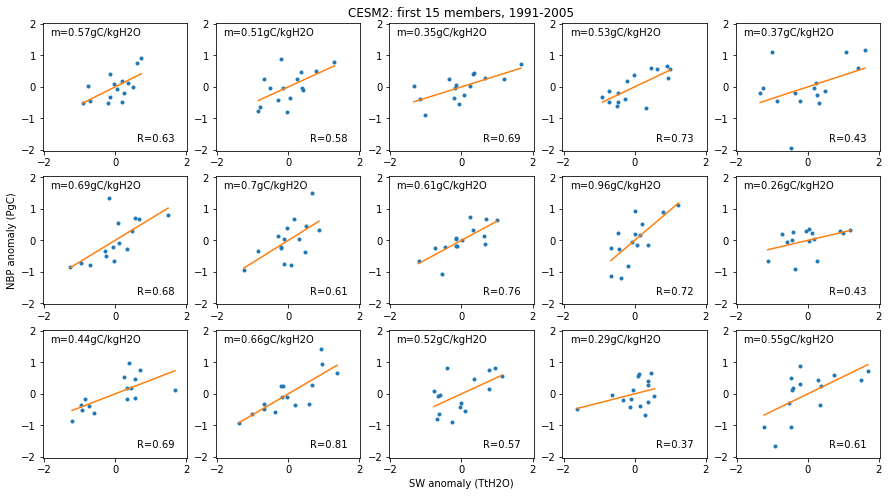

In [23]:
if model =='CESM1':
    output = cesm1
else:
    output = cesm2
plt.figure(figsize=[15,8])

themax = 0
for ee in range(15):
    xdt = output[ee][0]
    ydt = output[ee][1]
    themax = max(themax,max(abs(xdt)))
    themax = max(themax,max(abs(ydt)))
themax = 1.05*themax
    
for ee in range(15):
    plt.subplot(3,5,ee+1)
    xdt = output[ee][0]
    ydt = output[ee][1]
    m   = np.round(output[ee][2],2)
    r   = np.round(output[ee][3],2)
    xf  = output[ee][4]
    yf  = output[ee][5]
    plt.plot(xdt,ydt,'.')
    plt.plot(xf,yf)
    plt.ylim([-themax,themax])
    plt.xlim([-themax,themax])
    plt.text(-0.9*themax,0.8*themax,'m='+str(m)+'gC/kgH2O')
    plt.text(0.3*themax,-0.85*themax,'R='+str(r))
    if ee==2:
        plt.title(model+': first 15 members, 1991-2005')
    if ee==5:
        plt.ylabel('NBP anomaly (PgC)')
    if ee==12:
        plt.xlabel('SW anomaly (TtH2O)')

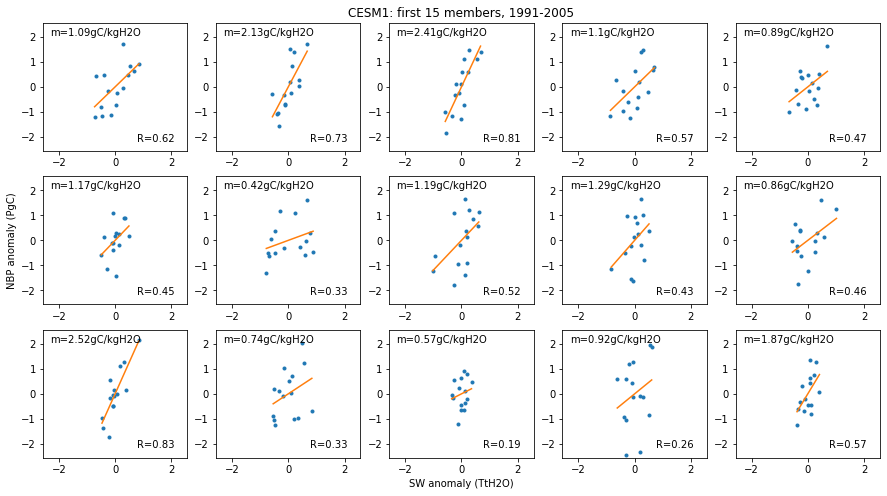

In [88]:
if model =='CESM1':
    output = cesm1
else:
    output = cesm2
plt.figure(figsize=[15,8])

themax = 0
for ee in range(15):
    xdt = output[ee][0]
    ydt = output[ee][1]
    themax = max(themax,max(abs(xdt)))
    themax = max(themax,max(abs(ydt)))
themax = 1.05*themax
    
for ee in range(15):
    plt.subplot(3,5,ee+1)
    xdt = output[ee][0]
    ydt = output[ee][1]
    m   = np.round(output[ee][2],2)
    r   = np.round(output[ee][3],2)
    xf  = output[ee][4]
    yf  = output[ee][5]
    plt.plot(xdt,ydt,'.')
    plt.plot(xf,yf)
    plt.ylim([-themax,themax])
    plt.xlim([-themax,themax])
    plt.text(-0.9*themax,0.8*themax,'m='+str(m)+'gC/kgH2O')
    plt.text(0.3*themax,-0.85*themax,'R='+str(r))
    if ee==2:
        plt.title(model+': first 15 members, 1991-2005')
    if ee==5:
        plt.ylabel('NBP anomaly (PgC)')
    if ee==12:
        plt.xlabel('SW anomaly (TtH2O)')

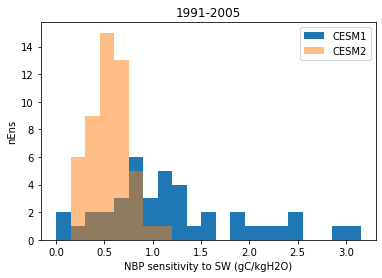

In [60]:
mvals1 = [cesm1[ee][2] for ee in range(40)]
mvals2 = [cesm2[ee][2] for ee in range(50)]
plt.hist(mvals1,0.15*np.arange(22))
plt.hist(mvals2,0.15*np.arange(22),alpha=0.5)
plt.legend(['CESM1','CESM2'])
plt.xlabel('NBP sensitivity to SW (gC/kgH2O)')
plt.ylabel('nEns')
plt.title('1991-2005');

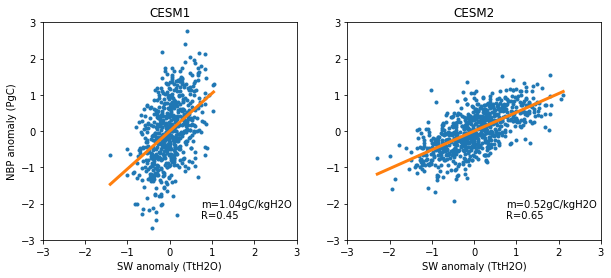

In [81]:
xdt = np.zeros(50*15)
ydt = np.zeros(50*15)
for ee in range(50):
    ix = np.arange(15)+15*ee
    xdt[ix] = cesm2[ee][0]
    ydt[ix] = cesm2[ee][1]
m,r,xfit,yfit = regress(xdt,ydt)

plt.figure(figsize=[10,4])
plt.subplot(122)
plt.plot(xdt,ydt,'.')
plt.plot(xfit,yfit,linewidth=3)
plt.text(0.75,-2.1,'m='+str(np.round(m,2))+'gC/kgH2O')
plt.text(0.75,-2.4,'R='+str(np.round(r,2)))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('SW anomaly (TtH2O)')
plt.title('CESM2')

xdt = np.zeros(40*15)
ydt = np.zeros(40*15)
for ee in range(40):
    ix = np.arange(15)+15*ee
    xdt[ix] = cesm1[ee][0]
    ydt[ix] = cesm1[ee][1]
m,r,xfit,yfit = regress(xdt,ydt)

plt.subplot(121)
plt.plot(xdt,ydt,'.')
plt.plot(xfit,yfit,linewidth=3)
plt.text(0.75,-2.1,'m='+str(np.round(m,2))+'gC/kgH2O')
plt.text(0.75,-2.4,'R='+str(np.round(r,2)))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.title('CESM1')
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('SW anomaly (TtH2O)');

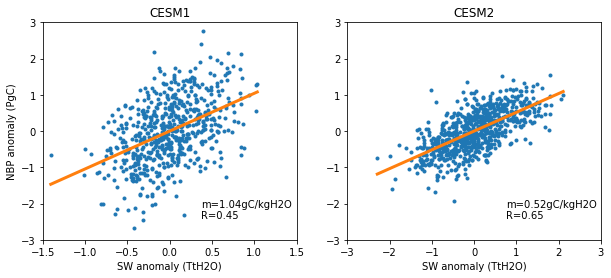

In [175]:
xdt = np.zeros(50*15)
ydt = np.zeros(50*15)
for ee in range(50):
    ix = np.arange(15)+15*ee
    xdt[ix] = cesm2[ee][0]
    ydt[ix] = cesm2[ee][1]
m,r,xfit,yfit = regress(xdt,ydt)

plt.figure(figsize=[10,4])
plt.subplot(122)
plt.plot(xdt,ydt,'.')
plt.plot(xfit,yfit,linewidth=3)
plt.text(0.75,-2.1,'m='+str(np.round(m,2))+'gC/kgH2O')
plt.text(0.75,-2.4,'R='+str(np.round(r,2)))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('SW anomaly (TtH2O)')
plt.title('CESM2')

xdt = np.zeros(40*15)
ydt = np.zeros(40*15)
for ee in range(40):
    ix = np.arange(15)+15*ee
    xdt[ix] = cesm1[ee][0]
    ydt[ix] = cesm1[ee][1]
m,r,xfit,yfit = regress(xdt,ydt)

plt.subplot(121)
plt.plot(xdt,ydt,'.')
plt.plot(xfit,yfit,linewidth=3)
plt.text(0.375,-2.1,'m='+str(np.round(m,2))+'gC/kgH2O')
plt.text(0.375,-2.4,'R='+str(np.round(r,2)))
plt.xlim([-1.5,1.5])
plt.ylim([-3,3])
plt.title('CESM1')
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('SW anomaly (TtH2O)');

### how many ensemble members?

In [44]:
pvalues = np.zeros([1000,20])
for nens in 1+np.arange(20):
    X     = np.zeros([2*nens*15,2])
    ydt   = np.zeros([2*nens*15,1])
    for j in range(1000):

        ix1 = np.random.choice(range(40), size=nens, replace=False)
        ix2 = np.random.choice(range(50), size=nens, replace=False)

        ct = -1
        for i in ix1:
            ct +=1
            ix = np.arange(15)+15*ct
            X[ix,0]   = cesm1[i][0]
            ydt[ix,0] = cesm1[i][1]
        for i in ix2:
            ct +=1
            ix = np.arange(15)+15*ct
            X[ix,0]    = cesm2[i][0]
            ydt[ix,0]  = cesm2[i][1]
            X[ix,1]    = cesm2[i][0]

        fit = sm.OLS(ydt, X).fit()
        pvalues[j,nens-1] = fit.pvalues[1]

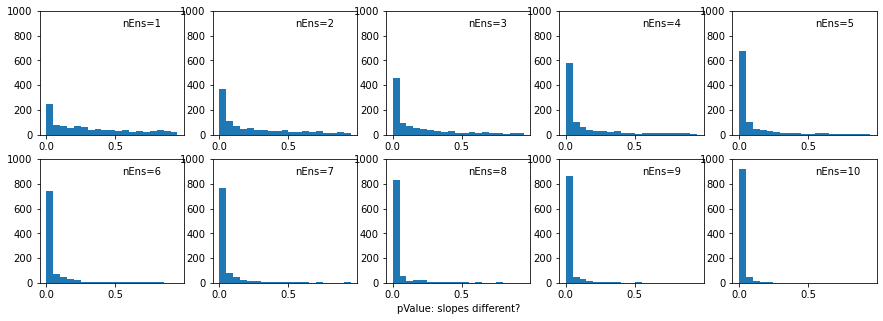

In [152]:
plt.figure(figsize=[15,5])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.hist(pvalues[:,i],0.05*np.arange(20))
    plt.ylim([0,1000])
    plt.text(0.55,875,'nEns='+str(i+1))
    if (i==7):
        plt.xlabel('pValue: slopes different?')

In [43]:
p = np.zeros(20)
for i in range(20):
    p[i] = (pvalues[:,i]<0.05).sum()/1000
    
plt.plot(1+np.arange(20),p,linewidth=3)
plt.xticks(5*np.arange(5))
plt.ylim([0,1])
plt.xlim([0,21])
plt.ylabel('chance of p<0.05')
plt.xlabel('number of ensemble members')
plt.title('Differentiating NBP~SW in CESM1 vs. CESM2');

NameError: name 'pvalues' is not defined

### present vs. future

In [220]:
%%time
model = 'CESM2'
firstyear = 2051
lastyear  = 2065
fields = ['NBP','SW','TBOT']

#look for annual data on disk
missing = []
for field in fields:
    file = '/glade/work/djk2120/LENSdata/'+model+'_'+field+'_ann_2051_2065.nc'
    if not os.path.exists(file):
        missing.append(field)
        
#if not found: read monthly data, annualize, and write to disk
if len(missing)>0:
    ens = np.arange(50)
    ds = get_monthly(model,ens,missing,firstyear,lastyear)        
    for field in missing:
        print(field)
        da_ann = aggregate_ann(ds[field],model,save=True)

#collect all the data 
das=[]
for field in fields:
    file = '/glade/work/djk2120/LENSdata/'+model+'_'+field+'_ann_2051_2065.nc'
    da_ann = xr.open_dataset(file)[field]
    das.append(da_ann)

nbp_ann,sw_ann,tbot_ann = das
la = get_landarea(model)

NBP
SW
TBOT
CPU times: user 32.7 s, sys: 36.7 s, total: 1min 9s
Wall time: 3min 6s


In [221]:
%%time
nbp_ann_glob  = aggregate_glob(nbp_ann,la)
sw_ann_glob   = aggregate_glob(sw_ann,la)
tbot_ann_glob = aggregate_glob(tbot_ann,la)

CPU times: user 799 ms, sys: 2.42 s, total: 3.22 s
Wall time: 2.97 s


In [222]:
ix = np.logical_and(nbp_ann.year>=2051,nbp_ann.year<=2065)
output = []
for ee in nbp_ann.ens:
    x = sw_ann_glob.sel(ens=ee).isel(year=ix)
    y = nbp_ann_glob.sel(ens=ee).isel(year=ix)
    xdt = detrend(x)
    ydt = detrend(y)
    out = regress(xdt,ydt)  #m,r,xfit,yfit
    output.append([xdt,ydt,*out])
    cesm2ssp = output

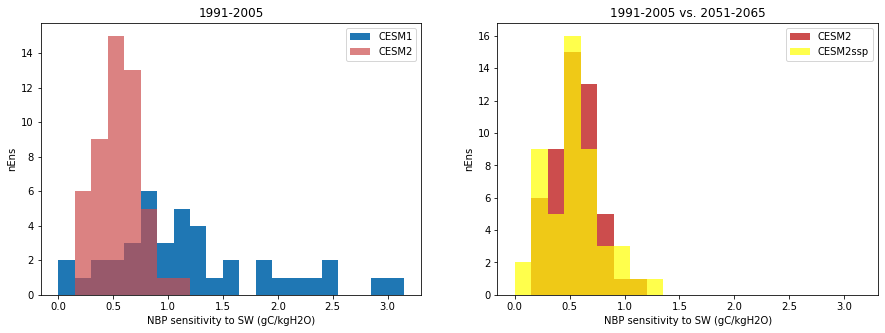

In [244]:
mvals2ssp = [cesm2ssp[ee][2] for ee in range(50)]

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.hist(mvals1,0.15*np.arange(22))
plt.hist(mvals2,0.15*np.arange(22),alpha=0.7,color=[0.8,0.3,0.3])
plt.legend(['CESM1','CESM2'])
plt.xlabel('NBP sensitivity to SW (gC/kgH2O)')
plt.ylabel('nEns')
plt.title('1991-2005')

plt.subplot(122)
plt.hist(mvals2,0.15*np.arange(22),color=[0.8,0.3,0.3])
plt.hist(mvals2ssp,0.15*np.arange(22),alpha=0.7,color='yellow')
plt.legend(['CESM2','CESM2ssp'])
plt.xlabel('NBP sensitivity to SW (gC/kgH2O)')
plt.ylabel('nEns')
plt.title('1991-2005 vs. 2051-2065');

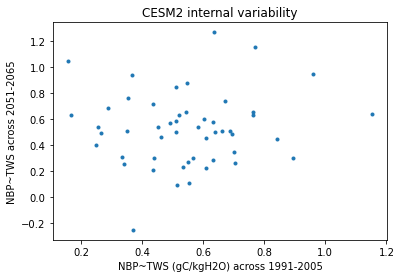

In [280]:
plt.plot(mvals2,mvals2ssp,'.')
plt.xlabel('NBP~TWS (gC/kgH2O) across 1991-2005')
plt.ylabel('NBP~TWS across 2051-2065')
plt.title('CESM2 internal variability');

In [251]:
X = np.zeros([2*50*15,2])
y = np.zeros([2*50*15,1])
for ee in range(50):
    ix = np.arange(15)+ee*15
    X[ix,0] = cesm2[ee][0]
    y[ix,0] = cesm2[ee][1]
    ix = 50*15+np.arange(15)+ee*15
    X[ix,0] = cesm2ssp[ee][0]
    X[ix,1] = cesm2ssp[ee][0]
    y[ix,0] = cesm2ssp[ee][1]

pValue for slopes different: 0.0835


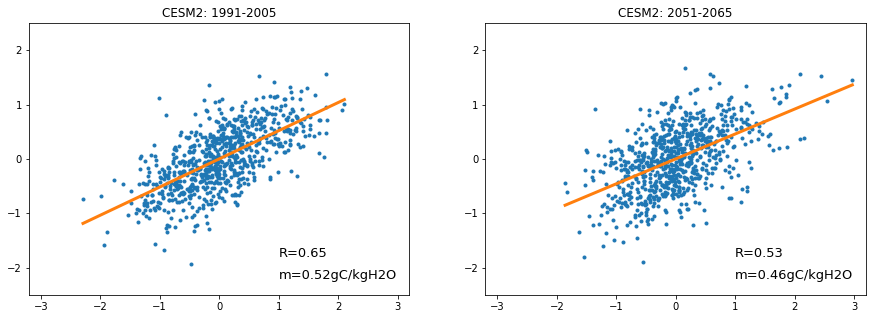

In [272]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(X[:50*15,0],y[:50*15,0],'.')
m,r,xfit,yfit = regress(X[:50*15,0],y[:50*15,0])
plt.plot(xfit,yfit,linewidth=3)
plt.xlim([-3.2,3.2])
plt.ylim([-2.5,2.5])
plt.text(1,-1.8,'R='+str(np.round(r,2)),fontsize=13)
plt.text(1,-2.2,'m='+str(np.round(m,2))+'gC/kgH2O',fontsize=13)
plt.title('CESM2: 1991-2005')
plt.subplot(122)
plt.plot(X[50*15:,0],y[50*15:,0],'.')
m,r,xfit,yfit = regress(X[50*15:,0],y[50*15:,0])
plt.plot(xfit,yfit,linewidth=3)
plt.xlim([-3.2,3.2])
plt.ylim([-2.5,2.5])
plt.text(1,-1.8,'R='+str(np.round(r,2)),fontsize=13)
plt.text(1,-2.2,'m='+str(np.round(m,2))+'gC/kgH2O',fontsize=13)
plt.title('CESM2: 2051-2065')
fit = sm.OLS(y, X).fit()
print('pValue for slopes different: '+str(np.round(fit.pvalues[1],4)))

### pooled regressions, one-at-a-time

In [34]:
if model =='CESM1':
    nens = 42
else:
    nens = 50

In [35]:
ix = np.logical_and(nbp_ann.year>1990,nbp_ann.year<=2005)
sw = detrend_dim(  sw_ann_glob.isel(year=ix),'year').values.ravel()
tb = detrend_dim(tbot_ann_glob.isel(year=ix),'year').values.ravel()
nb = detrend_dim( nbp_ann_glob.isel(year=ix),'year').values.ravel()

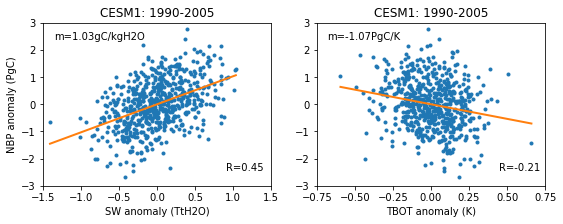

In [36]:
plt.figure(figsize=[9,3])
plt.subplot(121)
plt.plot(sw,nb,'.')
m1,r1,xfit,yfit = regress(sw,nb)
plt.plot(xfit,yfit,linewidth=2)
plt.ylim([-3,3])
plt.xlim([-1.5,1.5])
plt.text(-1.35,2.4,'m='+str(np.round(m1,2))+'gC/kgH2O')
plt.text(0.9,-2.42,'R='+str(np.round(r1,2)))
plt.title(model+': 1990-2005')
plt.ylabel('NBP anomaly (PgC)')
plt.xlabel('SW anomaly (TtH2O)')

plt.subplot(122)
plt.plot(tb,nb,'.')
m1,r1,xfit,yfit = regress(tb,nb)
plt.plot(xfit,yfit,linewidth=2)
plt.ylim([-3,3])
plt.xlim([-0.75,0.75])
plt.text(-0.68,2.4,'m='+str(np.round(m1,2))+'PgC/K')
plt.text(0.45,-2.42,'R='+str(np.round(r1,2)))
plt.title(model+': 1990-2005')
plt.xlabel('TBOT anomaly (K)');

### nee-sw regressions

In [34]:
sw_ann_glob   = aggregate_glob(sw_ann,la)
nee_ann_glob  = aggregate_glob(nee_ann,la)
ix = np.logical_and(nee_ann.year>1990,nee_ann.year<=2005)
output = []
for ee in nee_ann.ens:
    x = sw_ann_glob.sel(ens=ee).isel(year=ix)
    y = nee_ann_glob.sel(ens=ee).isel(year=ix)
    xdt = detrend(x)
    ydt = detrend(y)
    out = regress(xdt,ydt)  #m,r,xfit,yfit
    output.append([xdt,ydt,*out])

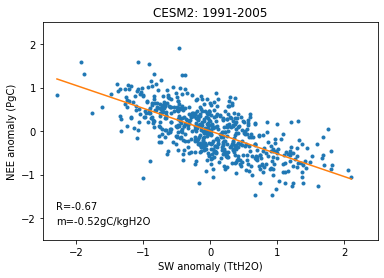

In [42]:
xdt = np.zeros(50*15)
ydt = np.zeros(50*15)
for ee in ens:
    ix = np.arange(15)+ee*15
    xdt[ix] = output[ee][0]
    ydt[ix] = output[ee][1]
    
m,r,xfit,yfit = regress(xdt,ydt)
plt.plot(xdt,ydt,'.')
plt.plot(xfit,yfit)
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
plt.text(-2.3,-1.8,'R='+str(np.round(r,2)))
plt.text(-2.3,-2.15,'m='+str(np.round(m,2))+'gC/kgH2O')
plt.ylabel('NEE anomaly (PgC)')
plt.xlabel('SW anomaly (TtH2O)')
plt.title('CESM2: 1991-2005');

### pooled regressions, multilinear

In [37]:
ny = 15
xdt = np.ndarray([ny*nens,2])
xdt[:,0] = sw
xdt[:,1] = tb
ydt = nb.reshape([-1,1])
lm = linear_model.LinearRegression()
lm.fit(xdt,ydt)

xfit1 = np.ndarray([ny*nens,2])
xfit1[:,0] = sw
xfit1[:,1] = 0
yfit1 = lm.predict(xfit1)

xfit2 = np.ndarray([ny*nens,2])
xfit2[:,0] = 0
xfit2[:,1] = tb
yfit2 = lm.predict(xfit2)

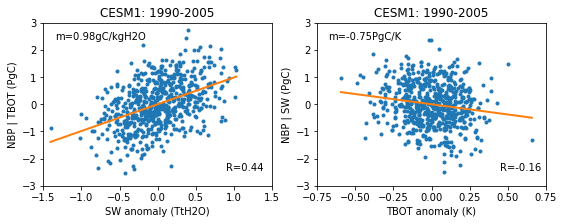

In [38]:
plt.figure(figsize=[9,3])
plt.subplot(121)
plt.plot(sw,nb-yfit2.ravel(),'.')
plt.plot([sw.min(),sw.max()],[yfit1.min(),yfit1.max()],linewidth=2)
plt.ylim([-3,3])
plt.xlim([-1.5,1.5])
m = np.round(lm.coef_[0,0],2)
r = np.round(np.corrcoef(sw,nb-yfit2.ravel())[0,1],2)
plt.text(-1.35,2.4,'m='+str(m)+'gC/kgH2O')
plt.text(0.9,-2.42,'R='+str(r))
plt.title(model+': 1990-2005')
plt.ylabel('NBP | TBOT (PgC)')
plt.xlabel('SW anomaly (TtH2O)')



plt.subplot(122)
plt.plot(tb,nb-yfit1.ravel(),'.')
plt.plot([tb.min(),tb.max()],[yfit2.max(),yfit2.min()],linewidth=2)
plt.ylim([-3,3])
plt.xlim([-0.75,0.75])
m = np.round(lm.coef_[0,1],2)
r = np.round(np.corrcoef(tb,nb-yfit1.ravel())[0,1],2)
plt.text(-0.68,2.4,'m='+str(m)+'PgC/K')
plt.text(0.45,-2.42,'R='+str(r))
plt.title(model+': 1990-2005')
plt.ylabel('NBP | SW (PgC)')
plt.xlabel('TBOT anomaly (K)');



In [66]:
x = []; y = []
x2= []; y2= []
for ee in range(50):
    x = [*x,*output[ee][0].values]
    y = [*y,*output[ee][1].values]
    x2 = [*x2,*output2[ee][0].values]
    y2 = [*y2,*output2[ee][1].values]

x=np.array(x); y=np.array(y)
x2=np.array(x2); y2=np.array(y2)
    
m1,r1,xfit1,yfit1 = regress(x,y)
m2,r2,xfit2,yfit2 = regress(x2,y2)



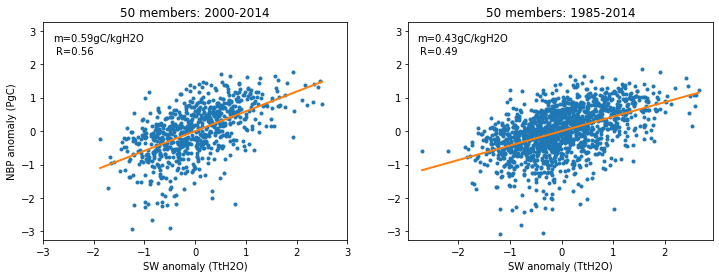

In [67]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.plot(x,y,'.')
plt.plot(xfit1,yfit1,linewidth=2)
plt.ylim([-3.25,3.25])
plt.xlim([-3,3])
plt.xlabel('SW anomaly (TtH2O)')
plt.ylabel('NBP anomaly (PgC)')
plt.title('50 members: 2000-2014')
plt.text(-2.8,2.7,'m='+str(np.round(m1,2))+'gC/kgH2O')
plt.text(-2.75,2.3,'R='+str(np.round(r1,2)))
plt.subplot(122)
plt.plot(x2,y2,'.')
plt.plot(xfit2,yfit2,linewidth=2)
plt.ylim([-3.25,3.25])
#plt.xlim([-3,3])
plt.text(-2.8,2.7,'m='+str(np.round(m2,2))+'gC/kgH2O')
plt.text(-2.75,2.3,'R='+str(np.round(r2,2)))
plt.title('50 members: 1985-2014')
plt.xlabel('SW anomaly (TtH2O)');

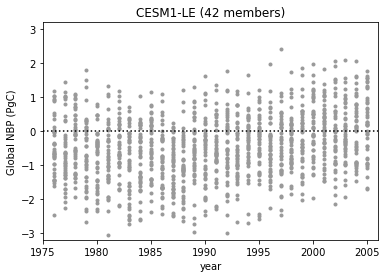

In [41]:
t = nbp_ann_glob.year
plt.plot(t,nbp_ann_glob.values,'.',color=[0.6,0.6,0.6]);
plt.plot([1975,2006],[0,0],'k:')
plt.xlim([1975,2006])
plt.ylim([-3.2,3.2])
plt.xlabel('year')
plt.ylabel('Global NBP (PgC)')
plt.title('CESM1-LE (42 members)');

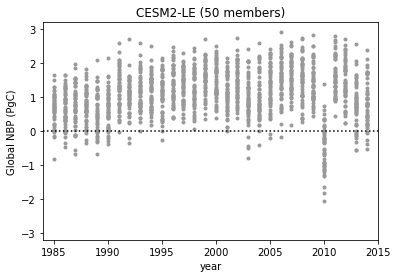

In [35]:
t = nbp_ann_glob.year
plt.plot(t,nbp_ann_glob.values,'.',color=[0.6,0.6,0.6]);
plt.plot([1984,2015],[0,0],'k:')
plt.xlim([1984,2015])
plt.ylim([-3.2,3.2])
plt.xlabel('year')
plt.ylabel('Global NBP (PgC)')
plt.title('CESM2-LE (50 members)');

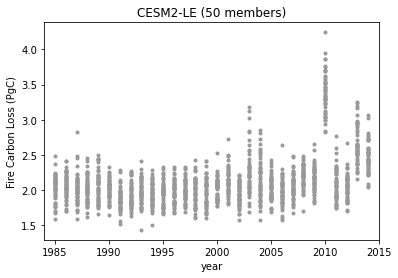

In [188]:
plt.plot(t,fire_ann_glob.values,'.',color=[0.6,0.6,0.6]);
plt.xlim([1984,2015])
plt.xlabel('year')
plt.ylabel('Fire Carbon Loss (PgC)')
plt.title('CESM2-LE (50 members)');

In [88]:


sw_dt   = np.zeros(50*ny)
nbp_dt  = np.zeros(50*ny)
tbot_dt = np.zeros(50*ny)

In [38]:
out = []
not2010 = []
yr2010 = []
ixt = nbp_ann.year>1999
ny  = ixt.sum().values
for da in [sw_ann_glob,tbot_ann_glob,nbp_ann_glob]:
    xdt = np.zeros(50*ny)
    this2010 = np.zeros(50)
    thisnot  = np.zeros(50*14)
    for ee in da.ens.values:
        x  = da.sel(ens=ee).isel(year=ixt)
        ix2010 = x.year==2010
        dt = detrend(x)
        ix = np.arange(ny)+ny*ee
        ix2 = np.arange(14)+14*ee
        xdt[ix] = dt
        this2010[ee] = dt[ix2010]
        thisnot[ix2]  = dt[~ix2010]
    out.append(xdt)
    yr2010.append(this2010)
    not2010.append(thisnot)
sw_dt,tbot_dt,nbp_dt = out
sw2010,tbot2010,nbp2010 = yr2010
swnot,tbotnot,nbpnot = not2010

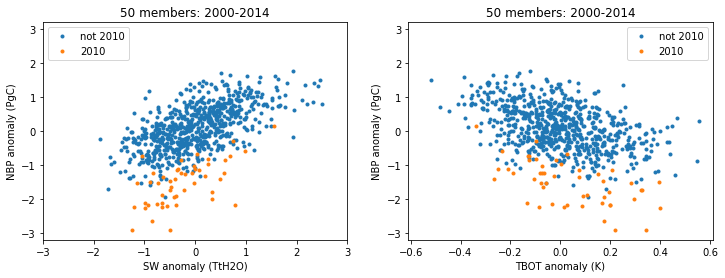

In [40]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.plot(swnot,nbpnot,'.')
plt.plot(sw2010,nbp2010,'.')
plt.xlim([-3,3])
plt.ylim([-3.2,3.2])
plt.xlabel('SW anomaly (TtH2O)')
plt.ylabel('NBP anomaly (PgC)')
plt.title('50 members: 2000-2014')
plt.legend(['not 2010','2010'],loc=2)
plt.subplot(122)
plt.plot(tbotnot,nbpnot,'.')
plt.plot(tbot2010,nbp2010,'.')
plt.xlim([-0.61,0.61])
plt.ylim([-3.2,3.2])
plt.xlabel('TBOT anomaly (K)')
plt.ylabel('NBP anomaly (PgC)')
plt.title('50 members: 2000-2014')
plt.legend(['not 2010','2010'],loc=1);

In [46]:
m1,r1,xfit1,yfit1 = regress(swnot,nbpnot)
print('exclude 2010:')
print('m='+str(np.round(m1,2)))
print('R='+str(np.round(r1,2)))

exclude 2010:
m=0.54
R=0.61


In [47]:
m1,r1,xfit1,yfit1 = regress(sw_dt,nbp_dt)
print('include 2010:')
print('m='+str(np.round(m1,2)))
print('R='+str(np.round(r1,2)))

include 2010:
m=0.59
R=0.56


In [57]:
out = []
ixt = np.logical_and(nbp_ann.year>1990,nbp_ann.year<=2005)
ny  = ixt.sum().values
for da in [sw_ann_glob,tbot_ann_glob,nbp_ann_glob]:
    xdt = np.zeros(50*ny)
    for ee in da.ens.values:
        x  = da.sel(ens=ee).isel(year=ixt)
        dt = detrend(x)
        ix = np.arange(ny)+ny*ee
        xdt[ix] = dt
    out.append(xdt)
sw_dt,tbot_dt,nbp_dt = out

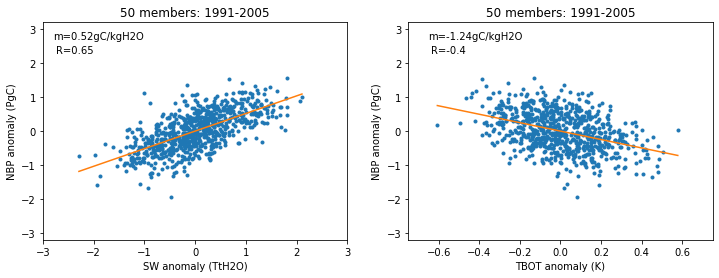

In [65]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.plot(sw_dt,nbp_dt,'.')
plt.xlim([-3,3])
plt.ylim([-3.2,3.2])
plt.xlabel('SW anomaly (TtH2O)')
plt.ylabel('NBP anomaly (PgC)')
plt.title('50 members: 1991-2005')
m1,r1,xfit1,yfit1 = regress(sw_dt,nbp_dt)
plt.plot(xfit1,yfit1)
plt.text(-2.8,2.7,'m='+str(np.round(m1,2))+'gC/kgH2O')
plt.text(-2.75,2.3,'R='+str(np.round(r1,2)))
plt.subplot(122)
plt.plot(tbot_dt,nbp_dt,'.')
plt.xlim([-0.75,0.75])
plt.ylim([-3.2,3.2])
plt.xlabel('TBOT anomaly (K)')
plt.ylabel('NBP anomaly (PgC)')
plt.title('50 members: 1991-2005')
m1,r1,xfit1,yfit1 = regress(tbot_dt,nbp_dt)
plt.plot(xfit1,yfit1)
plt.text(-0.65,2.7,'m='+str(np.round(m1,2))+'gC/kgH2O')
plt.text(-0.64,2.3,'R='+str(np.round(r1,2)));

### Multilinear regression

In [89]:
xdt = np.ndarray([750,2])
xdt[:,0] = sw_dt
xdt[:,1] = tbot_dt
ydt = nbp_dt.reshape([-1,1])
lm = linear_model.LinearRegression()
model = lm.fit(xdt,ydt)

In [103]:
xfit1 = np.ndarray([750,2])
xfit1[:,0] = sw_dt
xfit1[:,1] = 0
yfit1 = lm.predict(xfit1)

xfit2 = np.ndarray([750,2])
xfit2[:,0] = 0
xfit2[:,1] = tbot_dt
yfit2 = lm.predict(xfit2)

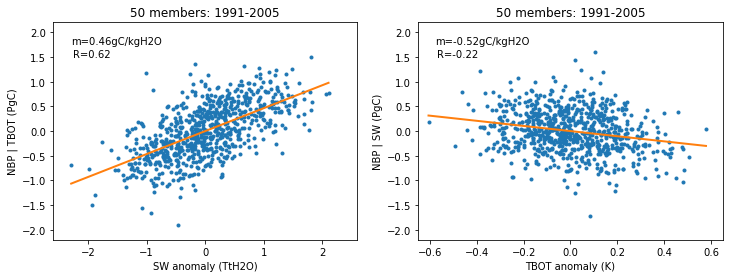

In [138]:
plt.figure(figsize=[12,4])
plt.subplot(121)
plt.plot(sw_dt,nbp_dt-yfit2.ravel(),'.')
plt.plot([sw_dt.min(),sw_dt.max()],[yfit1.min(),yfit1.max()],linewidth=2)
m1 = np.round(lm.coef_[0,0],2)
r1 = np.round(np.corrcoef(sw_dt,nbp_dt-yfit2.ravel())[0,1],2)
plt.text(-2.3,1.75,'m='+str(m1)+'gC/kgH2O')
plt.text(-2.26,1.5,'R='+str(r1))
plt.xlim([-2.6,2.6])
plt.ylim([-2.2,2.2])
plt.xlabel('SW anomaly (TtH2O)')
plt.ylabel('NBP | TBOT (PgC)')
plt.title('50 members: 1991-2005')

plt.subplot(122)
plt.plot(tbot_dt,nbp_dt-yfit1.ravel(),'.')
plt.plot([tbot_dt.min(),tbot_dt.max()],[yfit2.max(),yfit2.min()],linewidth=2)
m2 = np.round(lm.coef_[0,1],2)
r2 = np.round(np.corrcoef(tbot_dt,nbp_dt-yfit1.ravel())[0,1],2)
plt.text(-0.58,1.75,'m='+str(m2)+'gC/kgH2O')
plt.text(-0.57,1.5,'R='+str(r2))
plt.xlim([-0.65,0.65])
plt.ylim([-2.2,2.2])
plt.xlabel('TBOT anomaly (K)')
plt.ylabel('NBP | SW (PgC)')
plt.title('50 members: 1991-2005');

### gridcell level regression

In [42]:
if model =='CESM1':
    nens = 42

In [43]:
%%time
ix = np.logical_and(nbp_ann.year>1990,nbp_ann.year<=2005)
sw_dt   = detrend_dim(sw_ann.isel(year=ix),   'year', deg=1)
nbp_dt  = detrend_dim(nbp_ann.isel(year=ix),  'year', deg=1)
tbot_dt = detrend_dim(tbot_ann.isel(year=ix), 'year', deg=1)

CPU times: user 3.88 s, sys: 3.07 s, total: 6.94 s
Wall time: 7.18 s


In [44]:
ee = 0
ix = nbp_dt.sel(ens=ee).std(dim='year').values>0
lats = np.tile(np.arange(192).reshape([-1,1]),[1,288])[ix]
lons = np.tile(np.arange(288),[192,1])[ix]

In [45]:
%%time
ny  = 15
G = np.zeros([ny*nens,2])
m_sw   = np.zeros([192,288])+np.nan
m_tbot = np.zeros([192,288])+np.nan
r_sw   = np.zeros([192,288])+np.nan
r_tbot = np.zeros([192,288])+np.nan
for lat,lon in zip(lats,lons):
    G[:,0] = sw_dt.isel(lat=lat,lon=lon).values.ravel()
    G[:,1] = tbot_dt.isel(lat=lat,lon=lon).values.ravel()
    d = nbp_dt.isel(lat=lat,lon=lon).values.reshape([-1,1])
    m,a,b,c = np.linalg.lstsq(G, d, rcond=None)
    m_sw[lat,lon]   = m[0,0]
    m_tbot[lat,lon] = m[1,0]
    r_sw[lat,lon]   = np.corrcoef(G[:,0].ravel(),d.ravel())[0,1]
    r_tbot[lat,lon] = np.corrcoef(G[:,1].ravel(),d.ravel())[0,1]


CPU times: user 21.5 s, sys: 982 µs, total: 21.5 s
Wall time: 21.3 s


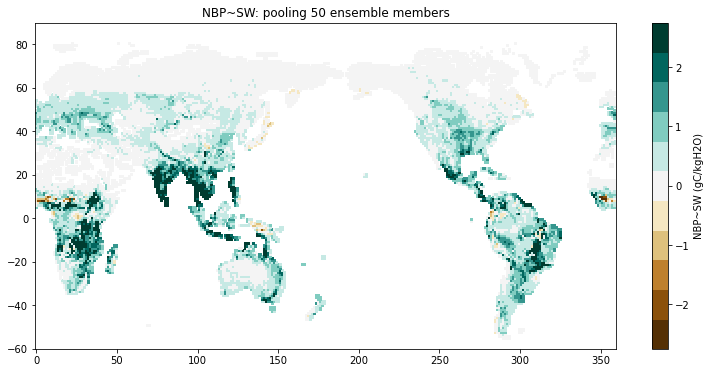

In [46]:
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,m_sw,cmap=ccc,vmin=-2.75,vmax=2.75,shading='auto')
plt.colorbar(label='NBP~SW (gC/kgH2O)')
plt.ylim([-60,90])
plt.title('NBP~SW: pooling 50 ensemble members');

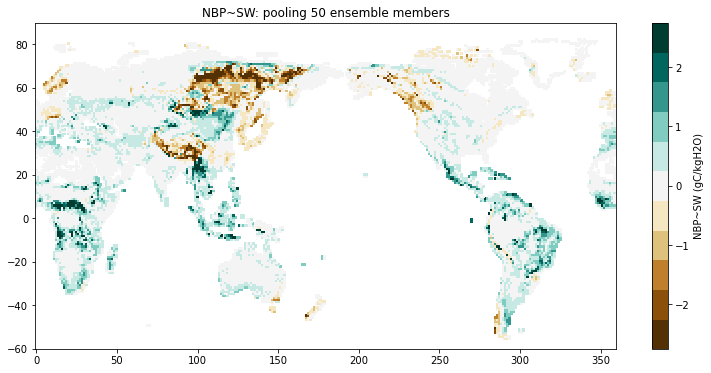

In [260]:
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,m_sw,cmap=ccc,vmin=-2.75,vmax=2.75,shading='auto')
plt.colorbar(label='NBP~SW (gC/kgH2O)')
plt.ylim([-60,90])
plt.title('NBP~SW: pooling 50 ensemble members');

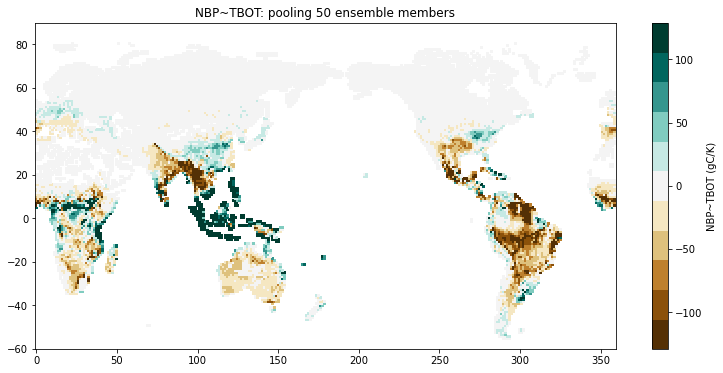

In [82]:
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,m_tbot,cmap=ccc,vmin=-129,vmax=129,shading='auto')
plt.colorbar(label='NBP~TBOT (gC/K)')
plt.ylim([-60,90])
plt.title('NBP~TBOT: pooling 50 ensemble members');

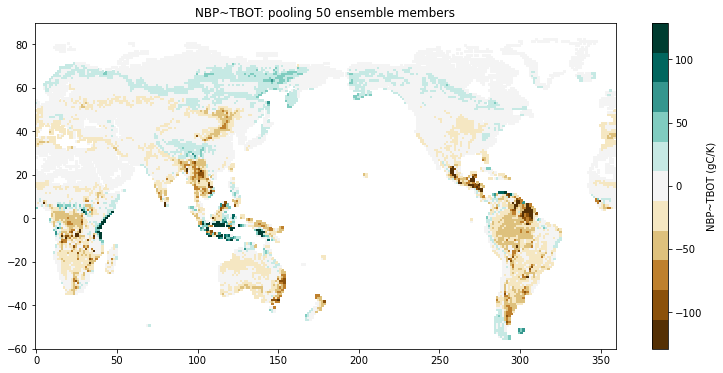

In [283]:
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,m_tbot,cmap=ccc,vmin=-129,vmax=129,shading='auto')
plt.colorbar(label='NBP~TBOT (gC/K)')
plt.ylim([-60,90])
plt.title('NBP~TBOT: pooling 50 ensemble members');

Text(0.1, 0.8, 'R0.05=0.07822')

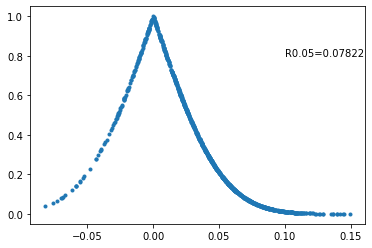

In [88]:
pvals = np.zeros(1000)
rvals = np.zeros(1000)
for i in range(1000):
    x = np.random.rand(nens*ny)
    y = 0.2*x+5*np.random.rand(nens*ny)
    m, b, r, p, std_err = stats.linregress(x,y)
    pvals[i]=p; rvals[i]=r
p5 = np.min(abs(pvals-0.05))
ix = abs(pvals-0.05)==p5
rthresh = rvals[ix][0]
plt.plot(rvals,pvals,'.')
plt.text(0.1,0.8,'R0.05='+str(np.round(rthresh,5)))

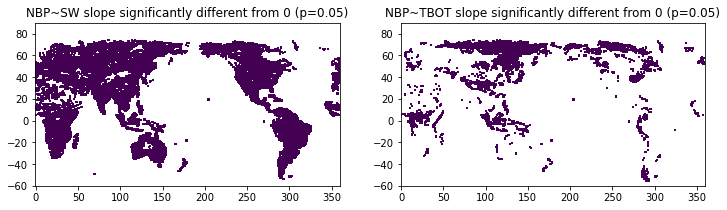

In [89]:
plt.figure(figsize=[12,3])
plt.subplot(121)
r = 0*r_sw+1
r[r_sw<rthresh]=np.nan
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,r,shading='auto')
plt.ylim([-60,90])
plt.title('NBP~SW slope significantly different from 0 (p=0.05)')

plt.subplot(122)
r = 0*r_tbot+1
r[r_tbot<rthresh]=np.nan
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,r,shading='auto')
plt.ylim([-60,90])
plt.title('NBP~TBOT slope significantly different from 0 (p=0.05)');



In [70]:
ny  = 15
G = np.zeros([ny*nens,1])
m   = np.zeros([192,288])+np.nan
r   = np.zeros([192,288])+np.nan
for lat,lon in zip(lats,lons):
    G[:,0] = tbot_dt.isel(lat=lat,lon=lon).values.ravel()
    d = sw_dt.isel(lat=lat,lon=lon).values.reshape([-1,1])
    thism,a,b,c = np.linalg.lstsq(G, d, rcond=None)
    m[lat,lon]   = thism[0,0]
    r[lat,lon]   = np.corrcoef(G[:,0].ravel(),d.ravel())[0,1]

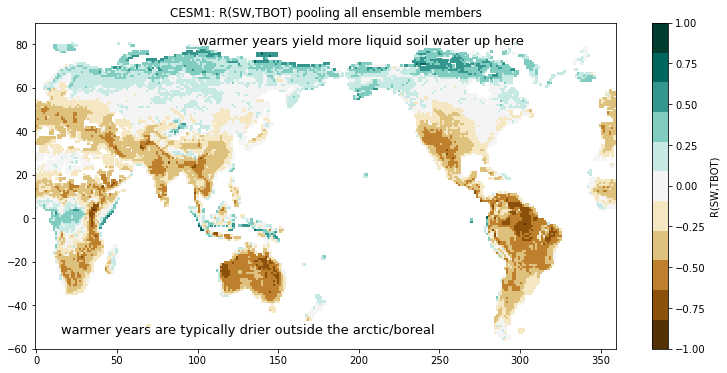

In [92]:
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,r,vmin=-1,vmax=1,cmap=ccc,shading='auto')
plt.colorbar(label='R(SW,TBOT)')
plt.ylim([-60,90])
plt.title(model+': R(SW,TBOT) pooling all ensemble members');
plt.text(15,-53,'warmer years are typically drier outside the arctic/boreal',fontsize=13);
plt.text(100,80,'warmer years yield more liquid soil water up here',fontsize=13);

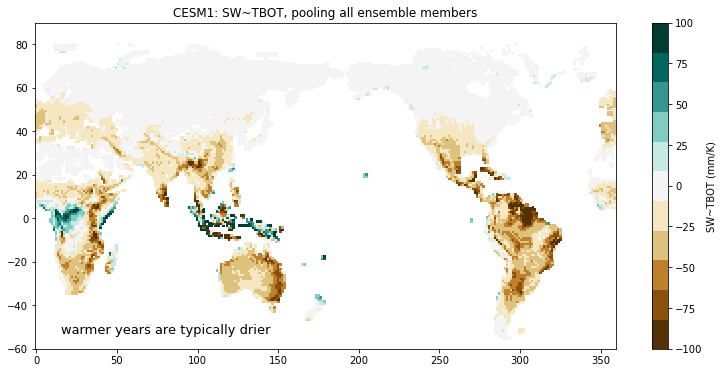

In [91]:
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,m,cmap=ccc,vmin=-100,vmax=100,shading='auto')
plt.colorbar(label='SW~TBOT (mm/K)')
plt.ylim([-60,90])
plt.title(model+': SW~TBOT, pooling all ensemble members');
plt.text(15,-53,'warmer years are typically drier',fontsize=13);

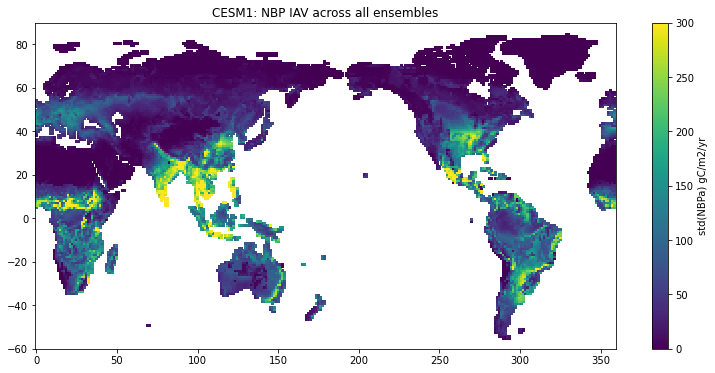

In [114]:
plotme = nbp_ann.std(skipna=True,dim=['year','ens'])
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,plotme.where(la>0),vmax=300,shading='auto')
plt.colorbar(label='std(NBPa) gC/m2/yr')
plt.ylim([-60,90])
plt.title(model+': NBP IAV across all ensembles');

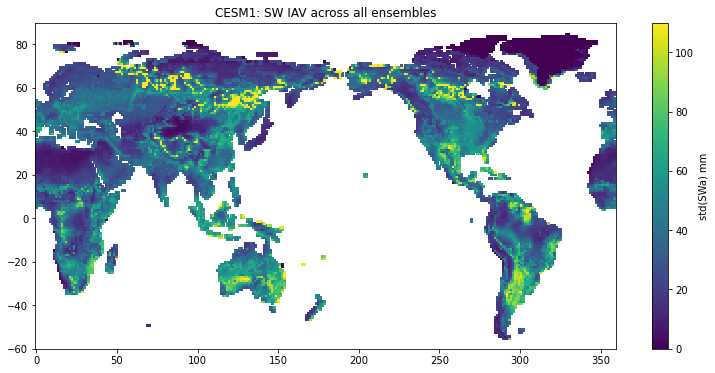

In [120]:
plotme = sw_ann.std(skipna=True,dim=['year','ens'])
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,plotme.where(la>0),vmax=110,shading='auto')
plt.colorbar(label='std(SWa) mm')
plt.ylim([-60,90])
plt.title(model+': SW IAV across all ensembles');

### look at nino34

In [53]:
yy1=1990; yy2=2005
ix = np.logical_and(nbp_ann.year>yy1,nbp_ann.year<=yy2)
nb  = detrend_dim(aggregate_glob(nbp_ann.isel(year=ix),la),'year').values.ravel()
sw  = detrend_dim(aggregate_glob(sw_ann.isel(year=ix),la),'year').values.ravel()
tb  = detrend_dim(aggregate_glob(tbot_ann.isel(year=ix),la),'year').values.ravel()

In [54]:
m, b, r, p, se = stats.linregress(sw,nb)
resids = nb-m*sw

In [55]:
t = nino34['time.year']
ix = np.logical_and(t>yy1,t<=yy2)
x = 1/365*(month_wts(15)*nino34.nino34.isel(time=ix)).groupby('time.year').sum().values.ravel()

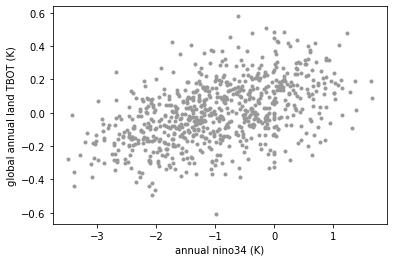

In [56]:
plt.plot(x,tb,'.',color=[0.6,0.6,0.6])
plt.xlabel('annual nino34 (K)');
plt.ylabel('global annual land TBOT (K)');

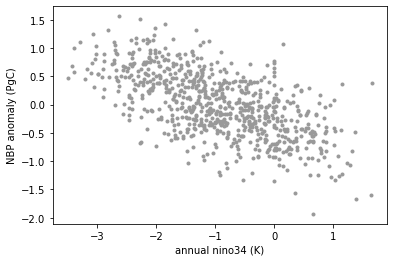

In [57]:
plt.plot(x,nb,'.',color=[0.6,0.6,0.6])
plt.xlabel('annual nino34 (K)');
plt.ylabel('NBP anomaly (PgC)');

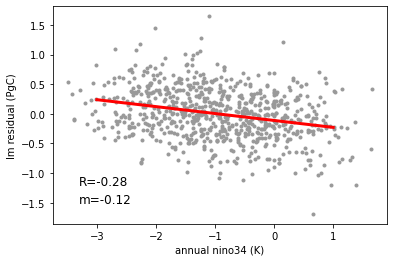

In [60]:
m, b, r, p, se = stats.linregress(x,resids)
xfit = np.array([-3,1])
plt.plot(x,resids,'.',color=[0.6,0.6,0.6])
plt.plot(xfit,m*xfit+b,'r',linewidth=3)
plt.xlabel('annual nino34 (K)');
plt.ylabel('lm residual (PgC)');
plt.text(-3.3,-1.2,'R='+str(np.round(r,2)),fontsize=12)
plt.text(-3.3,-1.5,'m='+str(np.round(m,2)),fontsize=12);

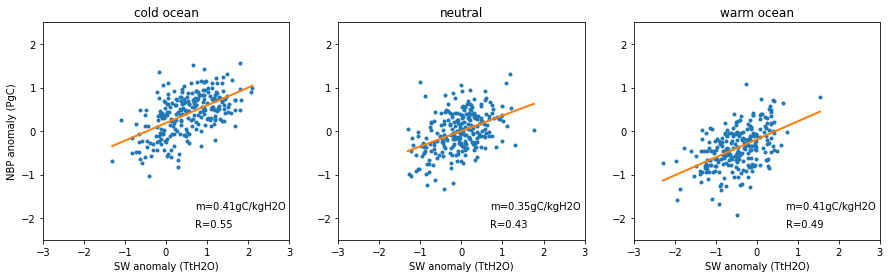

In [81]:
qq = [-np.inf,*np.quantile(x,[1/3,2/3]),np.inf]
titles = ['cold ocean','neutral','warm ocean']
plt.figure(figsize=[15,4])
for i in range(3):
    ix = np.logical_and(x>qq[i],x<=qq[i+1])
    xx = sw[ix]
    yy = nb[ix]
    
    m, b, r, p, se = stats.linregress(xx,yy)
    xfit = np.array([xx.min(),xx.max()])
    
    plt.subplot(1,3,i+1)
    plt.plot(xx,yy,'.')
    plt.plot(xfit,m*xfit+b,linewidth=2)
    plt.xlim([-3,3])
    plt.ylim([-2.5,2.5])
    plt.title(titles[i])
    plt.xlabel('SW anomaly (TtH2O)')
    if (i==0):
        plt.ylabel('NBP anomaly (PgC)')

    plt.text(0.7,-1.8,'m='+str(np.round(m,2))+'gC/kgH2O')
    plt.text(0.7,-2.2,'R='+str(np.round(r,2)))

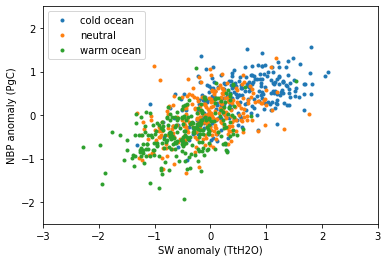

In [59]:
qq = [-np.inf,*np.quantile(x,[1/3,2/3]),np.inf]
titles = ['cold ocean','neutral','warm ocean']
for i in range(3):
    ix = np.logical_and(x>qq[i],x<=qq[i+1])
    xx = sw[ix]
    yy = nb[ix]
    
    plt.plot(xx,yy,'.')
    plt.xlim([-3,3])
    plt.ylim([-2.5,2.5])
    plt.legend(titles)
    plt.xlabel('SW anomaly (TtH2O)')
    plt.ylabel('NBP anomaly (PgC)')


In [91]:
yy1=1990; yy2=2005
ix = np.logical_and(nbp_ann.year>yy1,nbp_ann.year<=yy2)
nb  = detrend_dim(aggregate_glob(nbp_ann.isel(year=ix),la),'year').values
sw  = detrend_dim(aggregate_glob(sw_ann.isel(year=ix),la),'year').values
tb  = detrend_dim(aggregate_glob(tbot_ann.isel(year=ix),la),'year').values
t = nino34['time.year']
ix = np.logical_and(t>yy1,t<=yy2)
x = 1/365*(month_wts(15)*nino34.nino34.isel(time=ix)).groupby('time.year').sum(skipna=True).values

In [92]:
qq = [-np.inf,*np.quantile(x,[1/3,2/3]),np.inf]
warm = np.zeros(x.shape)+np.nan
for i in range(3):
    ix = np.logical_and(x>qq[i],x<=qq[i+1])
    warm[ix] = i
warm[:,-1]=np.nan   #last ens is missing as of now

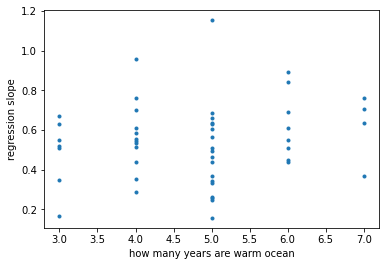

In [108]:
warmx = (warm==2).sum(axis=0).astype('float')
warmx[-1] = np.nan
plt.plot(warmx,mvals,'.')
plt.xlabel('how many years are warm ocean')
plt.ylabel('regression slope');

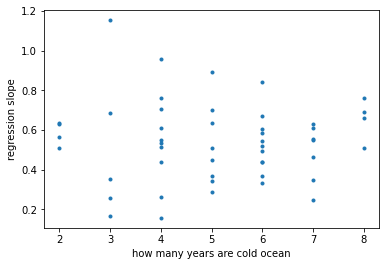

In [107]:
coldx = (warm==0).sum(axis=0).astype('float')
coldx[-1] = np.nan
plt.plot(coldx,mvals,'.')
plt.xlabel('how many years are cold ocean')
plt.ylabel('regression slope');

### Examine some anomalies

In [21]:
ix = np.logical_and(nbp_ann.year>1990,nbp_ann.year<=2005)
sw_dt = detrend_dim(  sw_ann.isel(year=ix),'year')
tb_dt = detrend_dim(tbot_ann.isel(year=ix),'year')
nb_dt = detrend_dim( nbp_ann.isel(year=ix),'year')

In [25]:
nb  = detrend_dim(aggregate_glob(nbp_ann.isel(year=ix),la),'year').values
sw  = detrend_dim(aggregate_glob(sw_ann.isel(year=ix),la),'year').values
tb  = detrend_dim(aggregate_glob(tbot_ann.isel(year=ix),la),'year').values

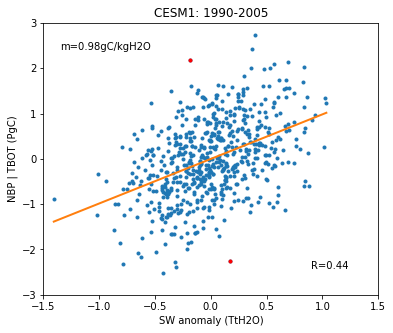

In [57]:
ny = ixt.sum().values
nens=42
xdt = np.ndarray([ny*nens,2])
xdt[:,0] = sw.ravel()
xdt[:,1] = tb.ravel()
ydt = nb.reshape([-1,1])
lm = linear_model.LinearRegression()
lm.fit(xdt,ydt)

xfit1 = np.ndarray([ny*nens,2])
xfit1[:,0] = sw.ravel()
xfit1[:,1] = 0
yfit1 = lm.predict(xfit1)

xfit2 = np.ndarray([ny*nens,2])
xfit2[:,0] = 0
xfit2[:,1] = tb.ravel()
yfit2 = lm.predict(xfit2)

plt.figure(figsize=[6,5])
plt.plot(sw.ravel(),nb.ravel()-yfit2.ravel(),'.')
plt.plot([sw.min(),sw.max()],[yfit1.min(),yfit1.max()],linewidth=2)
plt.ylim([-3,3])
plt.xlim([-1.5,1.5])
m = np.round(lm.coef_[0,0],2)
r = np.round(np.corrcoef(sw.ravel(),nb.ravel()-yfit2.ravel())[0,1],2)
plt.text(-1.35,2.4,'m='+str(m)+'gC/kgH2O')
plt.text(0.9,-2.42,'R='+str(r))
plt.title(model+': 1990-2005')
plt.ylabel('NBP | TBOT (PgC)')
plt.xlabel('SW anomaly (TtH2O)');
plt.plot(sw1,nbp1,'r.')
plt.plot(sw2,nbp2,'r.')

In [53]:
### farthest below the line

In [30]:
ixt = np.logical_and(nbp_ann.year>1990,nbp_ann.year<=2005)
yrs = np.tile(nbp_ann.year[ixt].values.reshape([-1,1]),[1,42])
ees = np.tile(nbp_ann.ens.values,[15,1])

In [28]:
x = sw.ravel()
y = nb.ravel()-yfit2.ravel()
ee = np.argmin(y-yfit1.ravel())
ix = sw == x[ee]
yy = yrs[ix]
ee = ees[ix]

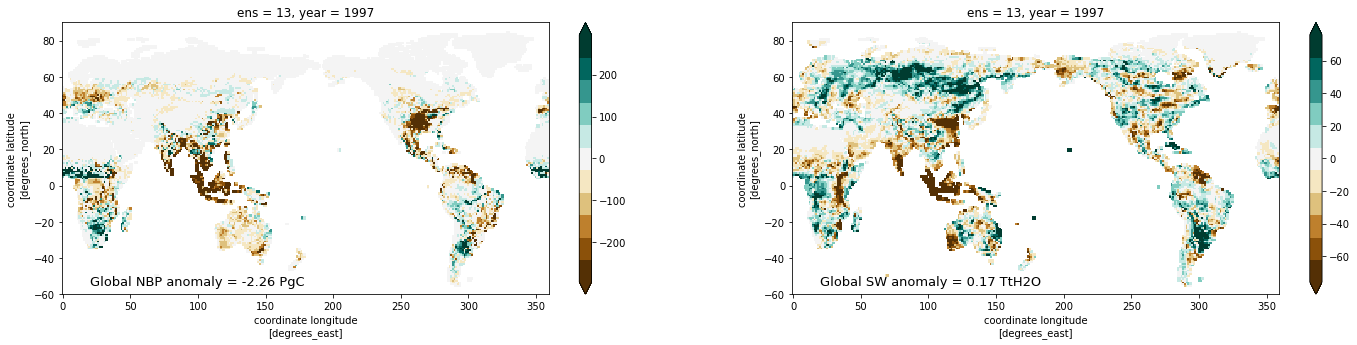

In [52]:
plt.figure(figsize=[24,5])
plt.subplot(121)
nb_dt.sel(year=yy,ens=ee).where(la>0).plot(cmap=ccc,robust=True)
nbp1 = (nb-yfit2.reshape([15,42]))[ix][0]
plt.ylim([-60,90])
plt.text(20,-55,'Global NBP anomaly = '+str(np.round(nbp1,2))+' PgC',fontsize=13);
plt.subplot(122)
sw_dt.sel(year=yy,ens=ee).where(la>0).plot(cmap=ccc,robust=True)
sw1 = sw[ix][0]
plt.ylim([-60,90])
plt.text(20,-55,'Global SW anomaly = '+str(np.round(sw1,2))+' TtH2O',fontsize=13);

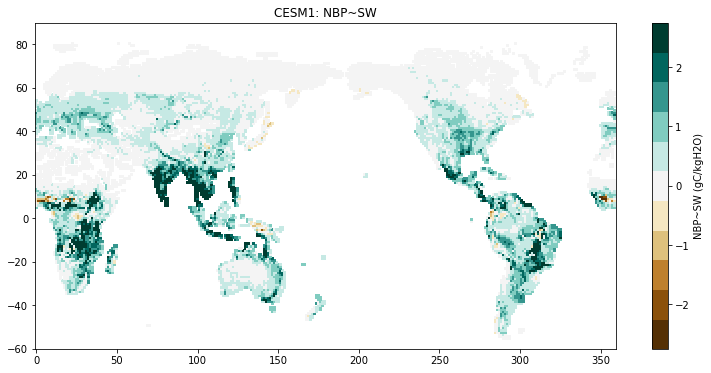

In [215]:
plt.figure(figsize=[13,6])
plt.pcolormesh(nbp_ann.lon,nbp_ann.lat,m_sw,cmap=ccc,vmin=-2.75,vmax=2.75,shading='auto')
plt.colorbar(label='NBP~SW (gC/kgH2O)')
plt.ylim([-60,90])
plt.title('CESM1: NBP~SW');

In [54]:
### farthest above the line

In [55]:
x = sw.ravel()
y = nb.ravel()-yfit2.ravel()
ee = np.argmax(y-yfit1.ravel())
ix = sw == x[ee]
yy = yrs[ix]
ee = ees[ix]

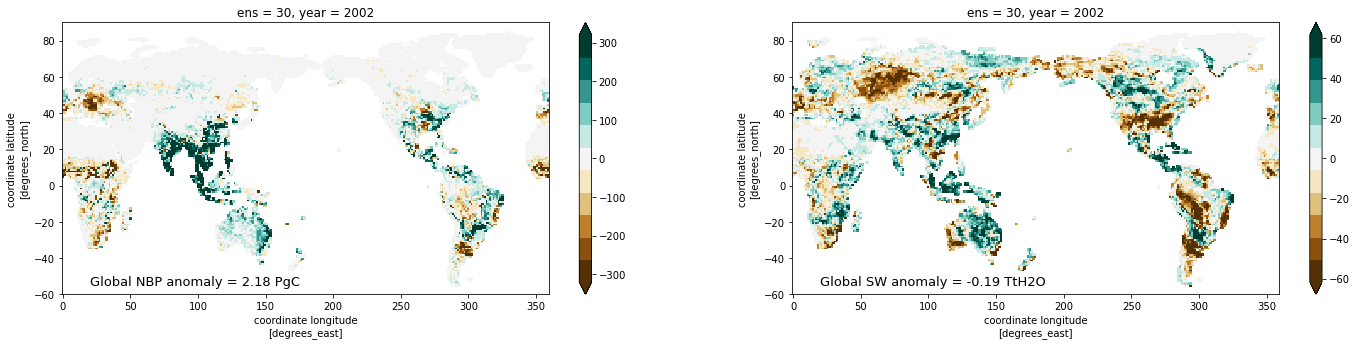

In [56]:
plt.figure(figsize=[24,5])
plt.subplot(121)
nb_dt.sel(year=yy,ens=ee).where(la>0).plot(cmap=ccc,robust=True)
nbp2 = (nb-yfit2.reshape([15,42]))[ix][0]
plt.ylim([-60,90])
plt.text(20,-55,'Global NBP anomaly = '+str(np.round(nbp2,2))+' PgC',fontsize=13);
plt.subplot(122)
sw_dt.sel(year=yy,ens=ee).where(la>0).plot(cmap=ccc,robust=True)
sw2 = sw[ix][0]
plt.ylim([-60,90])
plt.text(20,-55,'Global SW anomaly = '+str(np.round(sw2,2))+' TtH2O',fontsize=13);

In [116]:
nb2 = nb-yfit2.reshape([15,42])
nbest = 0.98*sw-nb2

In [120]:
#ix1 = np.logical_and(sw>0.46,sw<0.54)
ix1 = np.logical_and(sw<-0.46,sw>-0.54)
xx = np.min(abs(nbest[ix1]))
ix2 = abs(nbest)==xx
#ix2 = nb2<-0.97
ix = np.logical_and(ix1,ix2)
print(yrs[ix])
print(ees[ix])

[1998]
[31]


In [117]:
xx = np.min(abs(nbest[ix1]))

0.03719935802322172

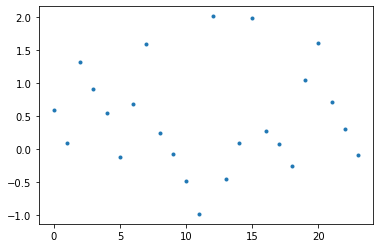

In [107]:
plt.plot(nb2[ix1],'.')

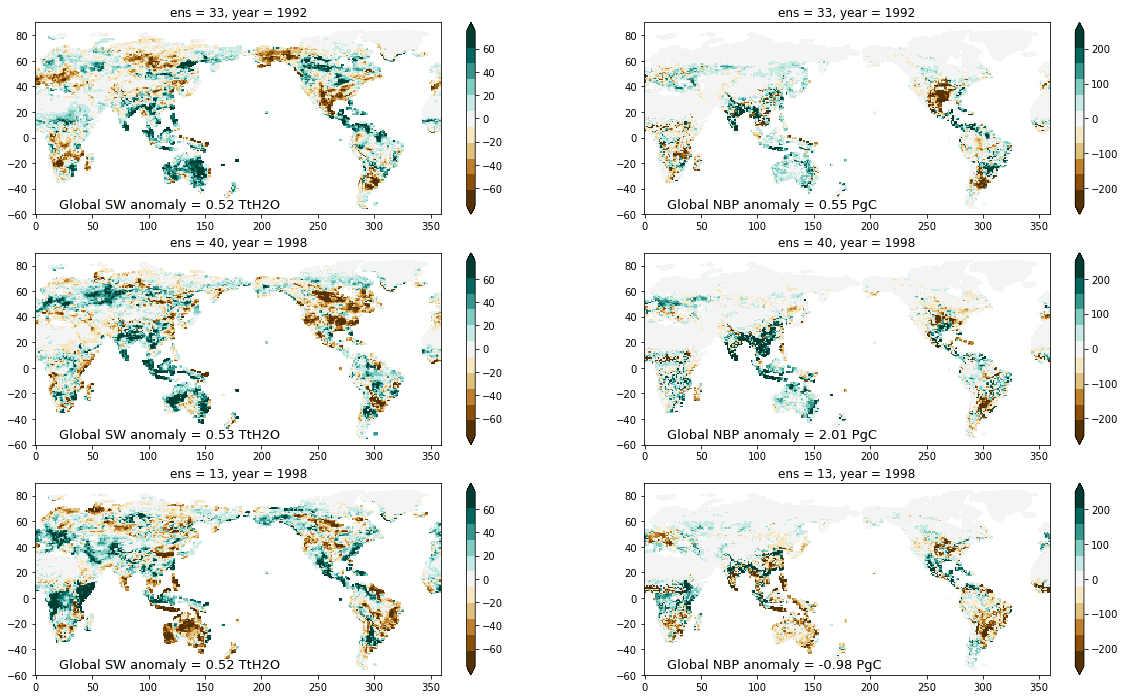

In [122]:
plt.figure(figsize=[20,12])
yvals = [1992,1998,1998]
evals = [33,40,13]
i = -1
for yy,ee in zip(yvals,evals):
    i+=1
    plt.subplot(3,2,1+2*i)
    sw_dt.sel(year=yy,ens=ee).where(la>0).plot(cmap=ccc,vmin=-75,vmax=75)
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim([-60,90])
    ix = np.logical_and(yrs==yy,ees==ee)
    thissw = sw[ix][0]
    plt.text(20,-55,'Global SW anomaly = '+str(np.round(thissw,2))+' TtH2O',fontsize=13)
    
    plt.subplot(3,2,2+2*i)
    nb_dt.sel(year=yy,ens=ee).where(la>0).plot(cmap=ccc,vmin=-250,vmax=250)
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim([-60,90])
    ix = np.logical_and(yrs==yy,ees==ee)
    thisnbp = nb2[ix][0]
    plt.text(20,-55,'Global NBP anomaly = '+str(np.round(thisnbp,2))+' PgC',fontsize=13);

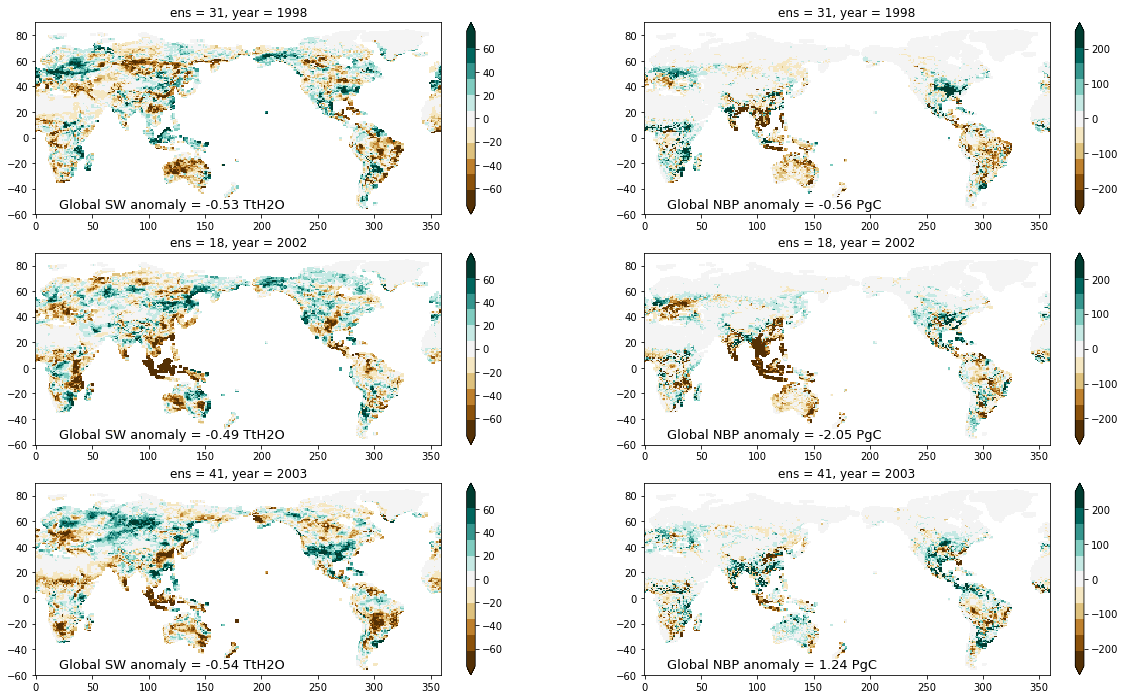

In [121]:
plt.figure(figsize=[20,12])
yvals = [1998,2002,2003]
evals = [31,18,41]
i = -1
for yy,ee in zip(yvals,evals):
    i+=1
    plt.subplot(3,2,1+2*i)
    sw_dt.sel(year=yy,ens=ee).where(la>0).plot(cmap=ccc,vmin=-75,vmax=75)
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim([-60,90])
    ix = np.logical_and(yrs==yy,ees==ee)
    thissw = sw[ix][0]
    plt.text(20,-55,'Global SW anomaly = '+str(np.round(thissw,2))+' TtH2O',fontsize=13)
    
    plt.subplot(3,2,2+2*i)
    nb_dt.sel(year=yy,ens=ee).where(la>0).plot(cmap=ccc,vmin=-250,vmax=250)
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim([-60,90])
    ix = np.logical_and(yrs==yy,ees==ee)
    thisnbp = nb2[ix][0]
    plt.text(20,-55,'Global NBP anomaly = '+str(np.round(thisnbp,2))+' PgC',fontsize=13);

## More stuff
 - enso indicator?
 - slope histograms
 - why do the slope histograms not aggregate
 - historical simulations
 - ssp simulations
 - does historical slope predict SSP slope?